# ResNet50 Model

Before running this notebook, please make sure to run the `AugmentAndSplit.ipynb` notebook beforehand.

## This notebook has the following sections:

1. Prerequisites

2. Grid Search

3. Training using the Best Hyperparameters

4. Model Evaluation using a Confusion Matrix

5. Model Evaluation using K-Fold Cross Validation

# Section 1 - Prerequisites

In this section, we will import all the necessary libraries to run the notebook, define constants and invariants, and define the architecture of our model.

In [1]:
"""
Log dependency versions for reproducibility
"""
import sys
print("python",  sys.version)
import matplotlib
print("matplotlib", matplotlib.__version__)
import pandas
print("pandas", pandas.__version__)
import numpy
print("numpy", numpy.__version__)
import keras
print("keras", keras.__version__)
import tensorflow
print("tensorflow", tensorflow.__version__)
import sklearn
print("sklearn", sklearn.__version__)
import scikeras
print("scikeras", scikeras.__version__)

python 3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
matplotlib 3.10.0
pandas 2.2.3
numpy 1.26.4
keras 3.9.0
tensorflow 2.15.0
sklearn 1.3.1
scikeras 0.13.0


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

# Loading Datasets and Models
from keras.utils import image_dataset_from_directory
from keras.saving import load_model

# Saving Results
import os
import json

# Building our Model
from keras import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.applications.resnet50 import ResNet50, preprocess_input # ResNet50

# Compiling our Model
from keras.optimizers import SGD, Adam, RMSprop

# Grid Search
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# K-Fold
from sklearn.model_selection import KFold

In [8]:
"""
Constants and Invariant Parameters
"""
# Invariant parameters
BATCH_SIZE = 16
EPOCHS = 10 # Due to limited hardware, we will only compute up to 10 epochs for realistic runtime constraints
VALIDATION_SPLIT = 0.2
SEED = 42

# Model tuning and evaluation
GRID_SEARCH_ITERATIONS = 3 # Number of attempts per hyperparameter combination (the score of these attempts will be averaged)
K_FOLDS = 5

# Constants
IMAGE_SIZE = (150, 150)
OPTIMIZERS = {
    "Adam": Adam,
    "SGD": SGD,
    "RMSprop": RMSprop,
}

# File and directory management
INPUT_DIRECTORY = "brain_tumor_dataset"
TESTING_DIRECTORY = "testing_dataset"
ORIGINAL_MODEL_NAME = "ResNet50"
MODEL_NAME = "ResNet50NoAugment"

In [5]:
"""
Define the model architecture
"""
resnet = ResNet50(
    input_shape=IMAGE_SIZE + tuple([3]), # (150, 150, 3)
    weights="imagenet",                  # Use pre-trained weights
    include_top=False,                   # Remove top layer to add our own layers
)

# Freeze the pre-trained weights
for layer in resnet.layers:
    layer.trainable = False

def create_model(optimizer="SGD", learning_rate=0.001):
    model = Sequential([
        resnet,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(1, activation="sigmoid")
    ])

    optimizer = OPTIMIZERS[optimizer]

    model.compile(
        optimizer=optimizer(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [11]:
"""
Load the training dataset
"""
training_dataset = image_dataset_from_directory(
    INPUT_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset="training",
    validation_split=VALIDATION_SPLIT,
    seed=SEED,
)
validation_dataset = image_dataset_from_directory(
    INPUT_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset="validation",
    validation_split=VALIDATION_SPLIT,
    seed=SEED,
)

# Apply ResNet50's image preprocessing
training_dataset = training_dataset.map(lambda x, y: (preprocess_input(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (preprocess_input(x), y))

Found 223 files belonging to 2 classes.
Using 179 files for training.
Found 223 files belonging to 2 classes.
Using 44 files for validation.


# Section 3 - Training using the Best Hyperparameters

In this section, we will train the model with the best hyperparameters, which were identified by the GridSearch results.

In [12]:
"""
Load the saved GridSearch results
"""
filtered_results = pd.read_csv(os.path.join(ORIGINAL_MODEL_NAME, "gridsearch.csv"))

# Get the top-ranked result (rank_test_score == 1)
best_result = filtered_results[filtered_results["rank_test_score"] == 1].iloc[0]

# Extract optimizer and learning rate
best_optimizer = best_result["param_model__optimizer"]
best_learning_rate = best_result["param_model__learning_rate"]

best_optimizer, best_learning_rate

('Adam', 0.001)

In [14]:
"""
Create a model with the best-performing hyperparameters identified by the GridSearch results
"""

best_model = create_model(
    optimizer=best_optimizer,
    learning_rate=best_learning_rate,
)

history = best_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 381ms/step - accuracy: 0.6592 - loss: 1.2904 - val_accuracy: 0.8409 - val_loss: 0.4892
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9266 - loss: 0.1938 - val_accuracy: 0.8409 - val_loss: 0.5900
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9777 - loss: 0.1141 - val_accuracy: 0.8182 - val_loss: 0.6551
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9821 - loss: 0.0738 - val_accuracy: 0.7955 - val_loss: 0.7586
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9901 - loss: 0.0420 - val_accuracy: 0.8409 - val_loss: 0.6925
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9864 - loss: 0.0333 - val_accuracy: 0.8409 - val_loss: 0.7413
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9718 - loss: 0.0406 - val_accuracy: 0.8182 - val_loss: 0.8152
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9933 - loss: 0.0408 - val_accuracy: 0.

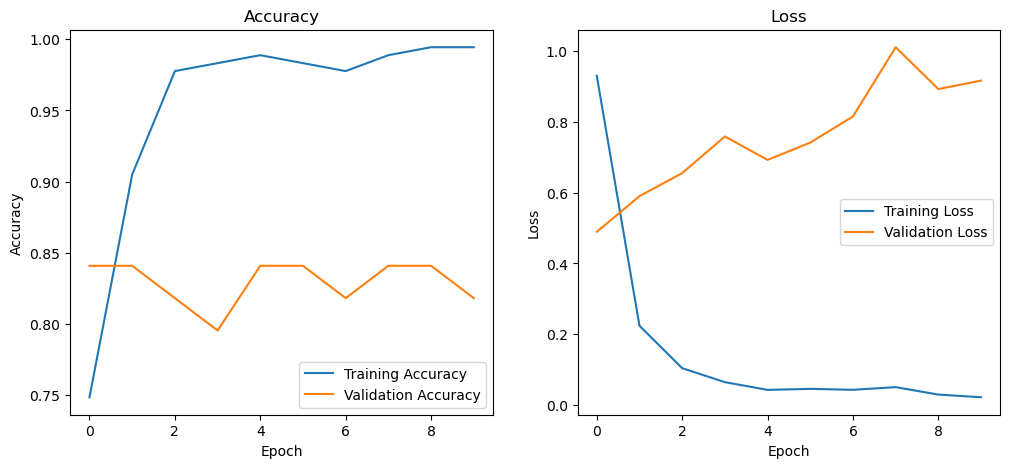

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8232 - loss: 1.1084
Test Accuracy: 0.82 Test Loss: 0.92


In [15]:
"""
Plot Accuracy & Loss for each Epoch
"""
plt.figure(figsize=(12, 5))

# Epoch vs Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"],     label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")

# Epoch vs Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"],     label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")

# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

plt.savefig(os.path.join(MODEL_NAME, "history.png"))
plt.show()

# Show Overall Performance
test_loss, test_acc = best_model.evaluate(validation_dataset)
print(f"Test Accuracy: {test_acc:.2f} Test Loss: {test_loss:.2f}")

In [16]:
"""
Save model and training history
"""
# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

with open(os.path.join(MODEL_NAME, "history.json"), "w") as file:
    json.dump(history.history, file)

best_model.save(os.path.join(MODEL_NAME, "model.keras"))

# Section 4 - Model Evaluation using a Confusion Matrix

In this section, we will use the best model from the previous section to create a Confusion Matrix.

In [17]:
"""
Load the model trained using the best hyperparameters
"""
best_model = load_model(os.path.join(MODEL_NAME, "model.keras"))

In [19]:
"""
Predict each image in the test dataset
"""
testing_dataset = image_dataset_from_directory(
    TESTING_DIRECTORY,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

# Apply ResNet50's image preprocessing
testing_dataset = testing_dataset.map(lambda x, y: (preprocess_input(x), y))

actual = []
predictions = []

for batch, labels in validation_dataset:
    results = best_model.predict(batch)  # Get raw predictions
    predicted_labels = (results > 0.5).astype(int).flatten()  # Convert probabilities to 0s and 1s
    predictions.extend(predicted_labels)  # Append predicted labels
    actual.extend(labels.numpy())  # Convert actual labels to list

print("Actual Labels:   ", actual)
print("Predicted Labels:", predictions)

Found 45 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Actual Labels:    [1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0]
Predicted Labels: [0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]


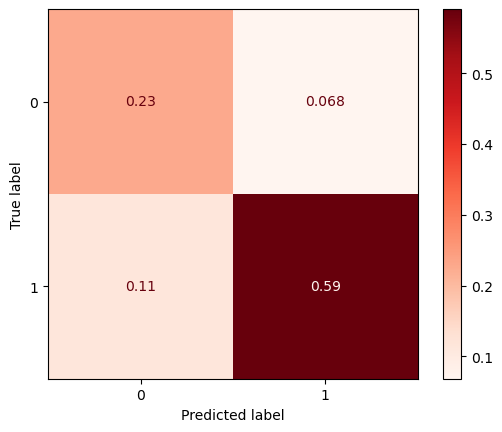

Accuracy: 0.8181818181818182


In [20]:
"""
Plot a Confusion Matrix of the test dataset predictions
"""
result = confusion_matrix(actual, predictions, normalize="all")

disp = ConfusionMatrixDisplay(confusion_matrix=result)
disp.plot(cmap="Reds")

# Ensure directory exists
os.makedirs(MODEL_NAME, exist_ok=True)

plt.savefig(os.path.join(MODEL_NAME, "confusionmatrix.png"))
plt.show()

with open(os.path.join(MODEL_NAME, "confusionmatrix.json"), "w") as file:
    json.dump(result.tolist(), file)

print(f"Accuracy: {result[0][0] + result[1][1]}")